In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

c:\Users\twelve\.conda\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
latent_size = 64  
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'img_GAN'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=0.5,std=0.5)])

# MNIST dataset
mnist = torchvision.datasets.MNIST('./data',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [3]:
# 构建判断器 
D = nn.Sequential( 
	nn.Linear(image_size, hidden_size), 
	nn.LeakyReLU(0.2), 
	nn.Linear(hidden_size, hidden_size), 
	nn.LeakyReLU(0.2), 
	nn.Linear(hidden_size, 1), 
	nn.Sigmoid())

D = D.to(device)

In [4]:
# 构建生成器
G = nn.Sequential(
	nn.Linear(latent_size, hidden_size), 
	nn.ReLU(), 
	nn.Linear(hidden_size, hidden_size), 
	nn.ReLU(), 
	nn.Linear(hidden_size, image_size), 
	nn.Tanh())

G = G.to(device)

Epoch [0/200], Step [600/600], d_loss: 0.0296, g_loss: 5.0803, D(x): 0.99, D(G(z)): 0.02
Epoch [1/200], Step [600/600], d_loss: 0.1741, g_loss: 4.5834, D(x): 0.96, D(G(z)): 0.10
Epoch [2/200], Step [600/600], d_loss: 0.1662, g_loss: 5.5027, D(x): 0.93, D(G(z)): 0.04
Epoch [3/200], Step [600/600], d_loss: 0.1475, g_loss: 3.3940, D(x): 0.94, D(G(z)): 0.05
Epoch [4/200], Step [600/600], d_loss: 0.1206, g_loss: 4.7457, D(x): 0.94, D(G(z)): 0.02
Epoch [5/200], Step [600/600], d_loss: 0.4063, g_loss: 4.3388, D(x): 0.92, D(G(z)): 0.17
Epoch [6/200], Step [600/600], d_loss: 0.5062, g_loss: 3.1278, D(x): 0.87, D(G(z)): 0.16
Epoch [7/200], Step [600/600], d_loss: 0.2673, g_loss: 2.7529, D(x): 0.89, D(G(z)): 0.05
Epoch [8/200], Step [600/600], d_loss: 0.4409, g_loss: 4.1331, D(x): 0.94, D(G(z)): 0.23
Epoch [9/200], Step [600/600], d_loss: 0.1815, g_loss: 2.8265, D(x): 0.95, D(G(z)): 0.09
Epoch [10/200], Step [600/600], d_loss: 0.3501, g_loss: 3.9315, D(x): 0.92, D(G(z)): 0.14
Epoch [11/200], Step

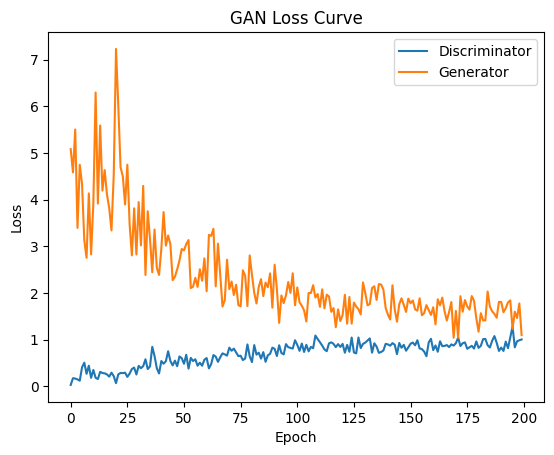

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# 定义损失函数以及优化器
# 二值交叉熵损失函数和优化器设置
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# 规范化处理
# 在Image processing中以mean,std=0.5进行规范化,out=2*input-1
# 故input=(out+1)/2
def denorm(x):
    out = (x + 1) / 2
    # 将out张量每个元素的范围限制到区间 [min,max]
    return out.clamp(0, 1)

# 梯度清零    
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


d_losses = []
g_losses = []

# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # 定义图像是真或假的标签 			
        real_labels = torch.ones(batch_size, 1).to(device) 
        fake_labels = torch.zeros(batch_size, 1).to(device) 
        # ================================================================== # 
        #                          训练判别器  K=1                            # 
        # ================================================================== # 
        # 定义判别器对真图像的损失函数
        outputs = D(images) # 真图像输入给鉴别器，并产生判别器输出
        # 计算由真图像输入给判别器产生的输出与真的label间的二值交叉熵损失
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs 

        # 定义判别器对假图像（即由潜在空间点生成的图像）的损失函数 
        z = torch.randn(batch_size, latent_size).to(device) 
        # 随机向量输入给生成器，并产生生成器输出假图像
        fake_images = G(z)
        outputs = D(fake_images) # 假图像输入给鉴别器，并产生判别器输出
        # 计算由假图像输入给判别器产生的输出与虚的label间的二值交叉熵损失
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # 得到判别器总的损失函数
        d_loss = d_loss_real + d_loss_fake 

        # 对生成器、判别器的梯度清零
        # 进行反向传播及运行判别器的优化器 
        reset_grad()
        d_loss.backward()
        d_optimizer.step() 
        # ================================================================== # 
        #                           训练生成器                                # 
        # ================================================================== # 
        # 定义生成器对假图像的损失函数
        z = torch.randn(batch_size, latent_size).to(device)

        # 随机向量输入给生成器，并产生生成器输出假图像
        fake_images = G(z)
        outputs = D(fake_images)  # 假图像输入给鉴别器，并产生判别器输出

        # 计算生成器生成的假图输入给鉴别器鉴别输出与真的label间的二值交叉熵损失
        g_loss = criterion(outputs, real_labels)

        # 对生成器、判别器的梯度清零
        reset_grad()
        # 进行反向传播及运行生成器的优化器 
        g_loss.backward()
        g_optimizer.step()



        # 每迭代一定步骤，打印结果值
        if (i + 1) % 600 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    # 保存真图像
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # 保存假图像
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.title('GAN Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()